# 实战Kaggle比赛：预测房价

## 下载和缓存数据集

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests # 把数据爬下来；

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
# 把数据保存在./data/ 下；
def download(name, cache_dir=os.path.join('.', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
        

我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
def download_extract(name, folder=None):  # 下载，提取
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 访问和读取数据集

注意，竞赛数据分为训练集和测试集。 每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。 这些特征由各种数据类型组成。 例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。 这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。 每套房子的价格只出现在训练集中（毕竟这是一场比赛）。 我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后， 我们只能在官方测试集中评估我们的模型。 在 图4.10.2 中，”Data”选项卡有下载数据的链接。

In [4]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
DATA_HUB

{'kaggle_house_train': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv',
  '585e9cc93e70b39160e7921475f9bcd7d31219ce'),
 'kaggle_house_test': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv',
  'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')}

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载./data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载./data/kaggle_house_pred_test.csv...


In [9]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签（房价）。-1

In [13]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理

In [15]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [16]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [17]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [18]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [19]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [22]:
n_train = train_data.shape[0]
print(n_train)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)

test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 样本y值
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

1460


## 训练

In [24]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)
# 线性预测模型，共有331列，331个特征；
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

331


实际应用中，数值特别大的，我们更关心相对误差；

解决办法是，使用rmse：均方根误差；

log 可以让变大更缓一点，想一想log图像
$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [25]:
def log_rmse(net, feartures, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1；
    clipped_preds = torch.clamp(net(feartures), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

优化器使用Adam，与前面的部分不同，我们的训练函数将借助Adam优化器 （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

SGD随机梯度下降 同类工具


In [26]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
- 我们首先需要定义一个函数，在折交叉验证过程中返回第i折的数据。 

In [30]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size) # 一折的样本大小；本质是一折有几行；
        X_part, y_part = X[idx, :], y[idx]
        if j == 1:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

- 验证 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [28]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

修改超参数，看效果 来进行模型选择

折1，训练log rmse0.162519, 验证log rmse0.190284
折2，训练log rmse0.162411, 验证log rmse0.190209
折3，训练log rmse0.162771, 验证log rmse0.192717
折4，训练log rmse0.162580, 验证log rmse0.192593
折5，训练log rmse0.162627, 验证log rmse0.188444
5-折验证: 平均训练log rmse: 0.162582, 平均验证log rmse: 0.190850


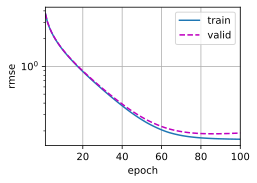

In [31]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.168883, 验证log rmse0.155940
折2，训练log rmse0.168749, 验证log rmse0.155949
折3，训练log rmse0.168762, 验证log rmse0.155727
折4，训练log rmse0.168828, 验证log rmse0.155956
折5，训练log rmse0.168935, 验证log rmse0.155603
折6，训练log rmse0.168776, 验证log rmse0.155900
6-折验证: 平均训练log rmse: 0.168822, 平均验证log rmse: 0.155846


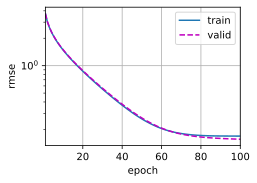

In [52]:
k, num_epochs, lr, weight_decay, batch_size = 6, 100, 5.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.167121, 验证log rmse0.150749
折2，训练log rmse0.167031, 验证log rmse0.151094
折3，训练log rmse0.166994, 验证log rmse0.151011
折4，训练log rmse0.167139, 验证log rmse0.151125
折5，训练log rmse0.167626, 验证log rmse0.151278
折6，训练log rmse0.167449, 验证log rmse0.150899
折7，训练log rmse0.167582, 验证log rmse0.150605
折8，训练log rmse0.167139, 验证log rmse0.151015
8-折验证: 平均训练log rmse: 0.167260, 平均验证log rmse: 0.150972


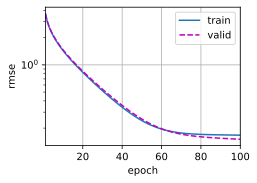

In [54]:
k, num_epochs, lr, weight_decay, batch_size = 8, 100, 5.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.165742, 验证log rmse0.140748
折2，训练log rmse0.166352, 验证log rmse0.140780
折3，训练log rmse0.166419, 验证log rmse0.140798
折4，训练log rmse0.166128, 验证log rmse0.140393
折5，训练log rmse0.166583, 验证log rmse0.140794
折6，训练log rmse0.166455, 验证log rmse0.140599
折7，训练log rmse0.166182, 验证log rmse0.140815
折8，训练log rmse0.166247, 验证log rmse0.140828
折9，训练log rmse0.166695, 验证log rmse0.140452
9-折验证: 平均训练log rmse: 0.166311, 平均验证log rmse: 0.140690


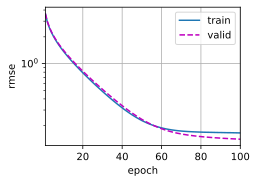

In [55]:
k, num_epochs, lr, weight_decay, batch_size = 9, 100, 5.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.166260, 验证log rmse0.140100
折2，训练log rmse0.166296, 验证log rmse0.140538
折3，训练log rmse0.165940, 验证log rmse0.139893
折4，训练log rmse0.166377, 验证log rmse0.140611
折5，训练log rmse0.165983, 验证log rmse0.140293
折6，训练log rmse0.166160, 验证log rmse0.140140
折7，训练log rmse0.166832, 验证log rmse0.140345
折8，训练log rmse0.166456, 验证log rmse0.140385
折9，训练log rmse0.166148, 验证log rmse0.139953
9-折验证: 平均训练log rmse: 0.166272, 平均验证log rmse: 0.140251


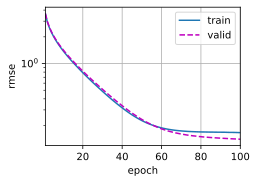

In [60]:
k, num_epochs, lr, weight_decay, batch_size = 9, 100, 5.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 提交你的Kaggle预测

In [61]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162107


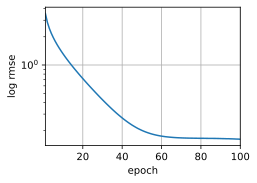

In [62]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)